In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
sess = tf.Session()

In [5]:
batch_size = 128
output_every = 50
generations = 2000
eval_every = 50
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
data_dir = 'advanced_data'
extract_folder = 'cifar-10-batches-bin'
learning_rate = 0.1
lr_decay = 0.9
num_gens_to_wait = 50
image_vec_length = image_height * image_width * num_channels 
record_length = 1 + image_vec_length

In [7]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
if not os.path.isfile(data_file):
    # Download file
    filepath, _ = urllib.request.urlretrieve(cifar10_url,data_file)
# Extract file
tarfile.open(filepath, 'r:gz').extractall(data_dir)

In [17]:
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    
    # Extract label
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)    
    
    # Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]), [num_channels, image_height, image_width])
    
    # Reshape image
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    
    # Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    if distort_images:
        # Randomly flip the image horizontally, change the brightness and contrast
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image,max_delta=63)
        final_image = tf.image.random_contrast(final_image,lower=0.2, upper=1.8)
    
    # Normalize whitening
    final_image = tf.image.per_image_standardization(final_image)
    
    return(final_image, image_label)

In [9]:
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]

    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    min_after_dequeue = 1000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch =  tf.train.shuffle_batch([image, label], batch_size, capacity, min_after_dequeue)
    return(example_batch, label_batch)

In [10]:
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    
    def truncated_normal_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.truncated_normal_initializer(stddev=0.05)))

    def zero_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.constant_initializer(0.0)))
    
    # First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        # Conv_kernel is 5x5 for all 3 colors and we will create 64 features
        conv1_kernel = truncated_normal_var(name='conv_kernel1', shape=[5, 5, 3, 64], dtype=tf.float32)
        # We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
        # Initialize and add the bias term
        conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        # ReLU element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    
    # Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool_layer1')
    # Local Response Normalization
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')
    
    # Second Convolutional Layer
    with tf.variable_scope('conv2') as scope:
        # Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name='conv_kernel2', shape=[5, 5, 64, 64], dtype=tf.float32)
        # Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        # Initialize and add the bias
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        # ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
        
    # Max Pooling
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer2')
    # Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    # Reshape output into a single matrix for multiplication for the fully connected layers
    reshaped_output = tf.reshape(norm2, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    # First Fully Connected Layer
    with tf.variable_scope('full1') as scope:
        # Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))
        
    # Second Fully Connected Layer
    with tf.variable_scope('full2') as scope:
        # Second fully connected layer has 192 outputs.
        full_weight2 = truncated_normal_var(name='full_mult2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))
    
    # Final Fully Connected Layer -> 10 categories for output (num_targets)
    with tf.variable_scope('full3') as scope:
        # Final fully connected layer has 10 (num_targets)outputs.
        full_weight3 = truncated_normal_var(name='full_mult3', shape=[192, num_targets], dtype=tf.float32)
        full_bias3 = zero_var(name='full_bias3', shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2,full_weight3), full_bias3)
    
    return(final_output)

In [11]:
def cifar_loss(logits, targets):
    # Get rid of extra dimensions and cast targets into integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Calculate cross entropy from logits and targets
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, targets)
    # Take the average loss across batch size
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    return(cross_entropy_mean)

In [12]:
def train_step(loss_value, generation_num):
    # Our learning rate is an exponential decay (stepped down)
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num, num_gens_to_wait, lr_decay, staircase=True)
    # Create optimizer
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    # Initialize train step
    train_step = my_optimizer.minimize(loss_value)
    return(train_step)

In [13]:
def accuracy_of_batch(logits, targets):
    # Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Get predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits, 1), tf.int32)
    # Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions, targets)
    # Average the 1's and 0's (True's and False's) across the batch size
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    return(accuracy)

In [18]:
images, targets = input_pipeline(batch_size, train_logical=True)
test_images, test_targets = input_pipeline(batch_size, train_logical=False)

In [19]:
with tf.variable_scope('model_definition') as scope:
    # Declare the training network model
    model_output = cifar_cnn_model(images, batch_size)
    # Use same variables within scope
    scope.reuse_variables()
    # Declare test model output
    test_output = cifar_cnn_model(test_images, batch_size)

In [20]:
loss = cifar_loss(model_output, targets)
accuracy = accuracy_of_batch(test_output, test_targets)
generation_num = tf.Variable(0, trainable=False)
train_op = train_step(loss, generation_num)

In [25]:
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[]

In [26]:
train_loss = []
test_accuracy = []
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i+1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i+1), loss_value)
        print(output)

    if (i+1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = ' --- Test Accuracy= {:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)

Generation 50: Loss = 1.94462
 --- Test Accuracy= 25.78%.
Generation 100: Loss = 2.06643
 --- Test Accuracy= 34.38%.
Generation 150: Loss = 1.83315
 --- Test Accuracy= 35.94%.
Generation 200: Loss = 1.75238
 --- Test Accuracy= 38.28%.
Generation 250: Loss = 1.68218
 --- Test Accuracy= 39.06%.
Generation 300: Loss = 1.47184
 --- Test Accuracy= 45.31%.
Generation 350: Loss = 1.55167
 --- Test Accuracy= 44.53%.
Generation 400: Loss = 1.49540
 --- Test Accuracy= 46.09%.
Generation 450: Loss = 1.45363
 --- Test Accuracy= 47.66%.
Generation 500: Loss = 1.38224
 --- Test Accuracy= 50.00%.
Generation 550: Loss = 1.45608
 --- Test Accuracy= 44.53%.
Generation 600: Loss = 1.43401
 --- Test Accuracy= 46.09%.
Generation 650: Loss = 1.52344
 --- Test Accuracy= 49.22%.
Generation 700: Loss = 1.28135
 --- Test Accuracy= 46.09%.
Generation 750: Loss = 1.40374
 --- Test Accuracy= 52.34%.
Generation 800: Loss = 1.21248
 --- Test Accuracy= 46.88%.
Generation 850: Loss = 1.19305
 --- Test Accuracy= 48.44%

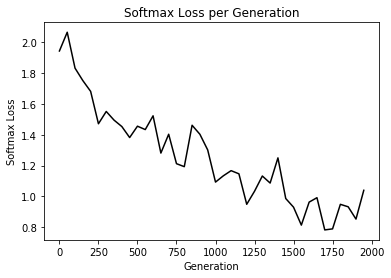

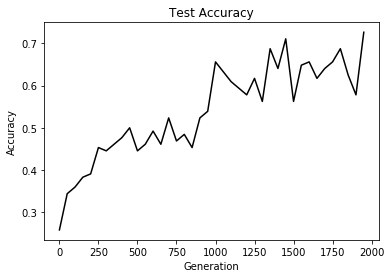

In [27]:
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)
# Plot loss over time
plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()
# Plot accuracy over time
plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()